# Optimize the bandwidth of RF Classification based on out-of-bag score

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mgwr
import numpy as np
import pandas as pd
from libpysal import graph

from gwlearn.ensemble import GWRandomForestClassifier
from gwlearn.linear_model import GWLinearRegression, GWLogisticRegression
from gwlearn.search import BandwidthSearch


In [3]:
elections = gpd.read_file(
    "https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg"
)
elections = elections.set_index("name")
education = pd.read_csv(
    "https://martinfleischmann.net/sds/regression/data/education.csv"
)
elections_data = elections.merge(education, left_on="nationalCode", right_on="uzemi_kod")
independent_names = education.columns.drop(["uzemi_kod", "okres"])

In [19]:
sample = elections_data.sample(500, random_state=10)

X = sample[independent_names[1:]]
y = sample["PetrPavel"]

See the progression of OOB score based on bandwidth using interval search.

<Axes: >

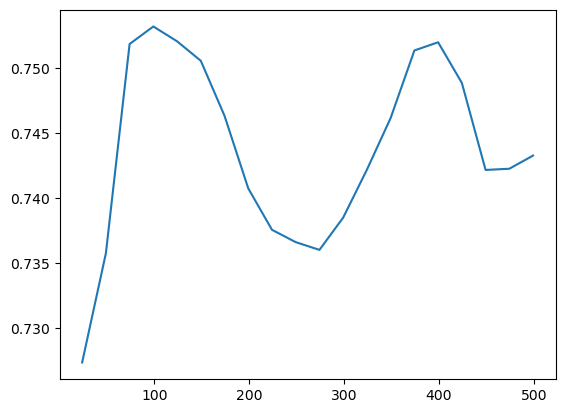

In [15]:
search_rf = BandwidthSearch(
    GWRandomForestClassifier,
    fixed=False,
    geometry=sample.centroid,
    search_method="interval",
    min_bandwidth=24,
    max_bandwidth=499,
    interval=25,
    max_iterations=10,
    tolerance=0.0005,
    criterion='oob_score',
    minimize=False,
    verbose=False,
    metrics=['oob_score', 'prediction_rate']
)
search_rf = search_rf.fit(X, y > 50)
search_rf.scores_.plot()

Optimize using golden section. It should find the peak (one of them).

In [16]:
search_section = BandwidthSearch(
    GWRandomForestClassifier,
    fixed=False,
    geometry=sample.centroid,
    search_method="golden_section",
    min_bandwidth=24,
    max_bandwidth=499,
    max_iterations=10,
    tolerance=0.0005,
    criterion='oob_score',
    minimize=False,
    verbose=False,
    metrics=['oob_score', 'prediction_rate']
)
search_section = search_section.fit(X, y > 50)

In [18]:
search_section.optimal_bandwidth_

np.int64(402)

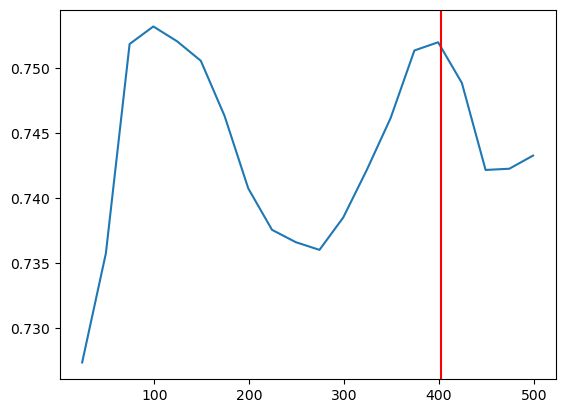

In [17]:
ax = search_rf.scores_.plot()
ax.axvline(search_section.optimal_bandwidth_, color='red')

It did find the peak as expected. Though not the globally optimal one due to the limitation of the golden section.